##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-08-12 01:23:24.420055: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-08-12 01:23:25.144734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-08-12 01:23:25.145032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-08-12 01:23:25.145046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

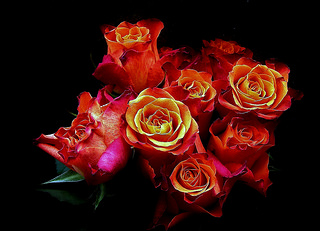

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

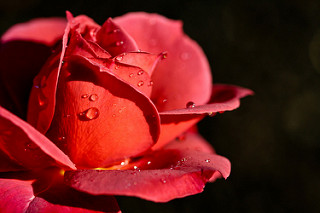

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

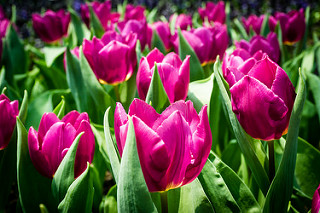

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

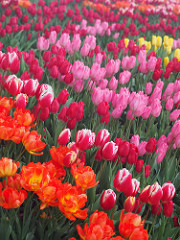

In [8]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

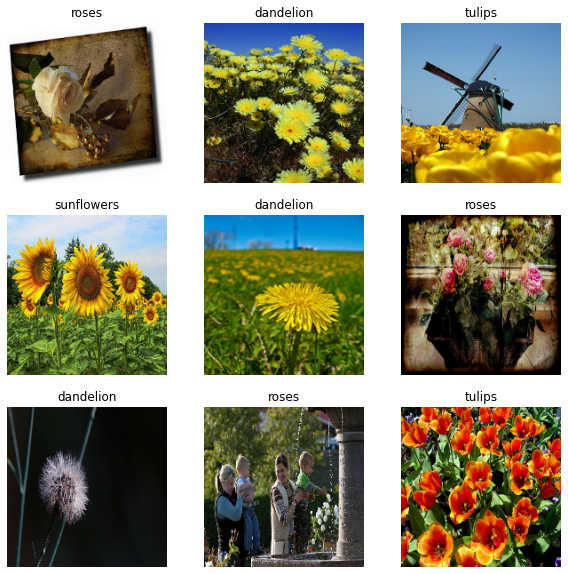

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9970691


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [20]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d (Conv2D)             (None, 180, 180, 16)      448       


 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 flatten (Flatten)           (None, 30976)             0         


 dense (Dense)               (None, 128)               3965056   


 dense_1 (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


 1/92 [..............................] - ETA: 2:38 - loss: 1.5952 - accuracy: 0.2188

 2/92 [..............................] - ETA: 9s - loss: 1.8223 - accuracy: 0.2500  

 6/92 [>.............................] - ETA: 2s - loss: 1.8920 - accuracy: 0.1957

10/92 [==>...........................] - ETA: 1s - loss: 1.7491 - accuracy: 0.2404

14/92 [===>..........................] - ETA: 1s - loss: 1.7041 - accuracy: 0.2591

18/92 [====>.........................] - ETA: 1s - loss: 1.6626 - accuracy: 0.2623

22/92 [======>.......................] - ETA: 1s - loss: 1.6332 - accuracy: 0.2687

26/92 [=======>......................] - ETA: 1s - loss: 1.5995 - accuracy: 0.2973

30/92 [========>.....................] - ETA: 0s - loss: 1.5732 - accuracy: 0.3130

34/92 [==========>...................] - ETA: 0s - loss: 1.5382 - accuracy: 0.3278

38/92 [===========>..................] - ETA: 0s - loss: 1.4940 - accuracy: 0.3477

42/92 [============>.................] - ETA: 0s - loss: 1.4574 - accuracy: 0.3668

46/92 [==============>...............] - ETA: 0s - loss: 1.4313 - accuracy: 0.3811

50/92 [===============>..............] - ETA: 0s - loss: 1.4151 - accuracy: 0.3876

54/92 [================>.............] - ETA: 0s - loss: 1.3968 - accuracy: 0.3959

58/92 [=================>............] - ETA: 0s - loss: 1.3817 - accuracy: 0.4031

62/92 [===================>..........] - ETA: 0s - loss: 1.3679 - accuracy: 0.4079

66/92 [====================>.........] - ETA: 0s - loss: 1.3502 - accuracy: 0.4192

70/92 [=====================>........] - ETA: 0s - loss: 1.3372 - accuracy: 0.4270

74/92 [=======================>......] - ETA: 0s - loss: 1.3222 - accuracy: 0.4335

78/92 [========================>.....] - ETA: 0s - loss: 1.3129 - accuracy: 0.4369

82/92 [=========================>....] - ETA: 0s - loss: 1.3039 - accuracy: 0.4427

86/92 [===========================>..] - ETA: 0s - loss: 1.2980 - accuracy: 0.4457

90/92 [============================>.] - ETA: 0s - loss: 1.2936 - accuracy: 0.4471

92/92 [==============================] - 3s 19ms/step - loss: 1.2910 - accuracy: 0.4479 - val_loss: 1.0880 - val_accuracy: 0.5490


Epoch 2/10


 1/92 [..............................] - ETA: 1s - loss: 0.9742 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 1s - loss: 1.0166 - accuracy: 0.5813

 9/92 [=>............................] - ETA: 1s - loss: 1.0138 - accuracy: 0.6042

13/92 [===>..........................] - ETA: 1s - loss: 1.0016 - accuracy: 0.6274

18/92 [====>.........................] - ETA: 0s - loss: 0.9979 - accuracy: 0.6391

22/92 [======>.......................] - ETA: 0s - loss: 0.9955 - accuracy: 0.6279

26/92 [=======>......................] - ETA: 0s - loss: 0.9781 - accuracy: 0.6335

30/92 [========>.....................] - ETA: 0s - loss: 0.9823 - accuracy: 0.6313

34/92 [==========>...................] - ETA: 0s - loss: 0.9834 - accuracy: 0.6333

38/92 [===========>..................] - ETA: 0s - loss: 0.9864 - accuracy: 0.6308

42/92 [============>.................] - ETA: 0s - loss: 0.9818 - accuracy: 0.6295

46/92 [==============>...............] - ETA: 0s - loss: 0.9736 - accuracy: 0.6332

50/92 [===============>..............] - ETA: 0s - loss: 0.9787 - accuracy: 0.6256

54/92 [================>.............] - ETA: 0s - loss: 0.9807 - accuracy: 0.6267

58/92 [=================>............] - ETA: 0s - loss: 0.9767 - accuracy: 0.6272

62/92 [===================>..........] - ETA: 0s - loss: 0.9763 - accuracy: 0.6280

66/92 [====================>.........] - ETA: 0s - loss: 0.9741 - accuracy: 0.6288

70/92 [=====================>........] - ETA: 0s - loss: 0.9751 - accuracy: 0.6272

74/92 [=======================>......] - ETA: 0s - loss: 0.9763 - accuracy: 0.6271

78/92 [========================>.....] - ETA: 0s - loss: 0.9752 - accuracy: 0.6286

82/92 [=========================>....] - ETA: 0s - loss: 0.9733 - accuracy: 0.6277

86/92 [===========================>..] - ETA: 0s - loss: 0.9719 - accuracy: 0.6272

90/92 [============================>.] - ETA: 0s - loss: 0.9707 - accuracy: 0.6274

92/92 [==============================] - 1s 15ms/step - loss: 0.9705 - accuracy: 0.6281 - val_loss: 0.9521 - val_accuracy: 0.6117


Epoch 3/10


 1/92 [..............................] - ETA: 1s - loss: 0.5588 - accuracy: 0.8438

 5/92 [>.............................] - ETA: 1s - loss: 0.7664 - accuracy: 0.7063

 9/92 [=>............................] - ETA: 1s - loss: 0.7991 - accuracy: 0.7083

13/92 [===>..........................] - ETA: 1s - loss: 0.7621 - accuracy: 0.7163

17/92 [====>.........................] - ETA: 0s - loss: 0.7538 - accuracy: 0.7188

21/92 [=====>........................] - ETA: 0s - loss: 0.7594 - accuracy: 0.7143

25/92 [=======>......................] - ETA: 0s - loss: 0.7919 - accuracy: 0.7075

29/92 [========>.....................] - ETA: 0s - loss: 0.7810 - accuracy: 0.7112

33/92 [=========>....................] - ETA: 0s - loss: 0.7933 - accuracy: 0.7036

37/92 [===========>..................] - ETA: 0s - loss: 0.7769 - accuracy: 0.7137

41/92 [============>.................] - ETA: 0s - loss: 0.7763 - accuracy: 0.7165

45/92 [=============>................] - ETA: 0s - loss: 0.7800 - accuracy: 0.7153

49/92 [==============>...............] - ETA: 0s - loss: 0.7760 - accuracy: 0.7149

53/92 [================>.............] - ETA: 0s - loss: 0.7771 - accuracy: 0.7140

57/92 [=================>............] - ETA: 0s - loss: 0.7706 - accuracy: 0.7149

61/92 [==================>...........] - ETA: 0s - loss: 0.7722 - accuracy: 0.7152

65/92 [====================>.........] - ETA: 0s - loss: 0.7746 - accuracy: 0.7135

69/92 [=====================>........] - ETA: 0s - loss: 0.7789 - accuracy: 0.7106

73/92 [======================>.......] - ETA: 0s - loss: 0.7883 - accuracy: 0.7063

77/92 [========================>.....] - ETA: 0s - loss: 0.7870 - accuracy: 0.7062

81/92 [=========================>....] - ETA: 0s - loss: 0.7905 - accuracy: 0.7049

86/92 [===========================>..] - ETA: 0s - loss: 0.7899 - accuracy: 0.7063

90/92 [============================>.] - ETA: 0s - loss: 0.7865 - accuracy: 0.7075

92/92 [==============================] - 1s 15ms/step - loss: 0.7879 - accuracy: 0.7071 - val_loss: 0.9698 - val_accuracy: 0.6104


Epoch 4/10


 1/92 [..............................] - ETA: 1s - loss: 0.5284 - accuracy: 0.7812

 5/92 [>.............................] - ETA: 1s - loss: 0.5860 - accuracy: 0.7937

 9/92 [=>............................] - ETA: 1s - loss: 0.6172 - accuracy: 0.7708

13/92 [===>..........................] - ETA: 1s - loss: 0.5936 - accuracy: 0.7740

18/92 [====>.........................] - ETA: 0s - loss: 0.6115 - accuracy: 0.7835

22/92 [======>.......................] - ETA: 0s - loss: 0.6060 - accuracy: 0.7816

26/92 [=======>......................] - ETA: 0s - loss: 0.6062 - accuracy: 0.7816

30/92 [========>.....................] - ETA: 0s - loss: 0.5828 - accuracy: 0.7920

34/92 [==========>...................] - ETA: 0s - loss: 0.5733 - accuracy: 0.7944

38/92 [===========>..................] - ETA: 0s - loss: 0.5729 - accuracy: 0.7939

42/92 [============>.................] - ETA: 0s - loss: 0.5730 - accuracy: 0.7972

46/92 [==============>...............] - ETA: 0s - loss: 0.5687 - accuracy: 0.7985

50/92 [===============>..............] - ETA: 0s - loss: 0.5688 - accuracy: 0.7959

54/92 [================>.............] - ETA: 0s - loss: 0.5621 - accuracy: 0.7971

58/92 [=================>............] - ETA: 0s - loss: 0.5685 - accuracy: 0.7933

62/92 [===================>..........] - ETA: 0s - loss: 0.5756 - accuracy: 0.7915

66/92 [====================>.........] - ETA: 0s - loss: 0.5777 - accuracy: 0.7899

70/92 [=====================>........] - ETA: 0s - loss: 0.5762 - accuracy: 0.7890

74/92 [=======================>......] - ETA: 0s - loss: 0.5759 - accuracy: 0.7898

78/92 [========================>.....] - ETA: 0s - loss: 0.5756 - accuracy: 0.7922

82/92 [=========================>....] - ETA: 0s - loss: 0.5773 - accuracy: 0.7913

86/92 [===========================>..] - ETA: 0s - loss: 0.5783 - accuracy: 0.7908

90/92 [============================>.] - ETA: 0s - loss: 0.5760 - accuracy: 0.7907

92/92 [==============================] - 1s 15ms/step - loss: 0.5747 - accuracy: 0.7919 - val_loss: 0.9599 - val_accuracy: 0.6417


Epoch 5/10


 1/92 [..............................] - ETA: 1s - loss: 0.3459 - accuracy: 0.8750

 5/92 [>.............................] - ETA: 1s - loss: 0.3103 - accuracy: 0.9125

 9/92 [=>............................] - ETA: 1s - loss: 0.3704 - accuracy: 0.8750

13/92 [===>..........................] - ETA: 1s - loss: 0.3557 - accuracy: 0.8798

17/92 [====>.........................] - ETA: 0s - loss: 0.3626 - accuracy: 0.8787

22/92 [======>.......................] - ETA: 0s - loss: 0.3858 - accuracy: 0.8649

26/92 [=======>......................] - ETA: 0s - loss: 0.3854 - accuracy: 0.8689

30/92 [========>.....................] - ETA: 0s - loss: 0.3753 - accuracy: 0.8750

34/92 [==========>...................] - ETA: 0s - loss: 0.3801 - accuracy: 0.8704

38/92 [===========>..................] - ETA: 0s - loss: 0.3855 - accuracy: 0.8700

42/92 [============>.................] - ETA: 0s - loss: 0.3813 - accuracy: 0.8713

46/92 [==============>...............] - ETA: 0s - loss: 0.3723 - accuracy: 0.8723

50/92 [===============>..............] - ETA: 0s - loss: 0.3679 - accuracy: 0.8737

54/92 [================>.............] - ETA: 0s - loss: 0.3687 - accuracy: 0.8727

58/92 [=================>............] - ETA: 0s - loss: 0.3649 - accuracy: 0.8734

62/92 [===================>..........] - ETA: 0s - loss: 0.3580 - accuracy: 0.8740

66/92 [====================>.........] - ETA: 0s - loss: 0.3587 - accuracy: 0.8726

70/92 [=====================>........] - ETA: 0s - loss: 0.3618 - accuracy: 0.8719

74/92 [=======================>......] - ETA: 0s - loss: 0.3631 - accuracy: 0.8716

78/92 [========================>.....] - ETA: 0s - loss: 0.3605 - accuracy: 0.8714

82/92 [=========================>....] - ETA: 0s - loss: 0.3642 - accuracy: 0.8712

86/92 [===========================>..] - ETA: 0s - loss: 0.3679 - accuracy: 0.8699

90/92 [============================>.] - ETA: 0s - loss: 0.3675 - accuracy: 0.8712

92/92 [==============================] - 1s 15ms/step - loss: 0.3659 - accuracy: 0.8716 - val_loss: 1.1058 - val_accuracy: 0.6471


Epoch 6/10


 1/92 [..............................] - ETA: 1s - loss: 0.1913 - accuracy: 0.9375

 5/92 [>.............................] - ETA: 1s - loss: 0.2310 - accuracy: 0.9250

 9/92 [=>............................] - ETA: 1s - loss: 0.2046 - accuracy: 0.9271

13/92 [===>..........................] - ETA: 1s - loss: 0.2073 - accuracy: 0.9255

17/92 [====>.........................] - ETA: 0s - loss: 0.1996 - accuracy: 0.9320

21/92 [=====>........................] - ETA: 0s - loss: 0.1932 - accuracy: 0.9390

25/92 [=======>......................] - ETA: 0s - loss: 0.1974 - accuracy: 0.9375

29/92 [========>.....................] - ETA: 0s - loss: 0.1939 - accuracy: 0.9407

33/92 [=========>....................] - ETA: 0s - loss: 0.1990 - accuracy: 0.9375

37/92 [===========>..................] - ETA: 0s - loss: 0.1996 - accuracy: 0.9383

41/92 [============>.................] - ETA: 0s - loss: 0.2000 - accuracy: 0.9383

45/92 [=============>................] - ETA: 0s - loss: 0.2007 - accuracy: 0.9375

49/92 [==============>...............] - ETA: 0s - loss: 0.2002 - accuracy: 0.9381

53/92 [================>.............] - ETA: 0s - loss: 0.2035 - accuracy: 0.9346

57/92 [=================>............] - ETA: 0s - loss: 0.2033 - accuracy: 0.9348

61/92 [==================>...........] - ETA: 0s - loss: 0.2033 - accuracy: 0.9349

65/92 [====================>.........] - ETA: 0s - loss: 0.1993 - accuracy: 0.9365

69/92 [=====================>........] - ETA: 0s - loss: 0.1982 - accuracy: 0.9370

73/92 [======================>.......] - ETA: 0s - loss: 0.1995 - accuracy: 0.9371

78/92 [========================>.....] - ETA: 0s - loss: 0.1994 - accuracy: 0.9365

82/92 [=========================>....] - ETA: 0s - loss: 0.1985 - accuracy: 0.9362

86/92 [===========================>..] - ETA: 0s - loss: 0.2012 - accuracy: 0.9333

90/92 [============================>.] - ETA: 0s - loss: 0.2036 - accuracy: 0.9314

92/92 [==============================] - 1s 15ms/step - loss: 0.2075 - accuracy: 0.9298 - val_loss: 1.2884 - val_accuracy: 0.6158


Epoch 7/10


 1/92 [..............................] - ETA: 1s - loss: 0.0913 - accuracy: 1.0000

 5/92 [>.............................] - ETA: 1s - loss: 0.1552 - accuracy: 0.9688

 9/92 [=>............................] - ETA: 1s - loss: 0.1388 - accuracy: 0.9722

13/92 [===>..........................] - ETA: 1s - loss: 0.1306 - accuracy: 0.9760

17/92 [====>.........................] - ETA: 0s - loss: 0.1365 - accuracy: 0.9706

21/92 [=====>........................] - ETA: 0s - loss: 0.1256 - accuracy: 0.9762

25/92 [=======>......................] - ETA: 0s - loss: 0.1250 - accuracy: 0.9737

29/92 [========>.....................] - ETA: 0s - loss: 0.1295 - accuracy: 0.9709

33/92 [=========>....................] - ETA: 0s - loss: 0.1267 - accuracy: 0.9697

37/92 [===========>..................] - ETA: 0s - loss: 0.1187 - accuracy: 0.9721

41/92 [============>.................] - ETA: 0s - loss: 0.1191 - accuracy: 0.9703

45/92 [=============>................] - ETA: 0s - loss: 0.1179 - accuracy: 0.9708

49/92 [==============>...............] - ETA: 0s - loss: 0.1169 - accuracy: 0.9707

53/92 [================>.............] - ETA: 0s - loss: 0.1200 - accuracy: 0.9688

57/92 [=================>............] - ETA: 0s - loss: 0.1208 - accuracy: 0.9677

61/92 [==================>...........] - ETA: 0s - loss: 0.1248 - accuracy: 0.9662

65/92 [====================>.........] - ETA: 0s - loss: 0.1272 - accuracy: 0.9654

69/92 [=====================>........] - ETA: 0s - loss: 0.1256 - accuracy: 0.9660

73/92 [======================>.......] - ETA: 0s - loss: 0.1242 - accuracy: 0.9670

77/92 [========================>.....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9659

81/92 [=========================>....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9664

85/92 [==========================>...] - ETA: 0s - loss: 0.1227 - accuracy: 0.9665

90/92 [============================>.] - ETA: 0s - loss: 0.1249 - accuracy: 0.9652

92/92 [==============================] - 1s 15ms/step - loss: 0.1258 - accuracy: 0.9646 - val_loss: 1.6268 - val_accuracy: 0.6322


Epoch 8/10


 1/92 [..............................] - ETA: 1s - loss: 0.1930 - accuracy: 0.9062

 5/92 [>.............................] - ETA: 1s - loss: 0.1116 - accuracy: 0.9563

 9/92 [=>............................] - ETA: 1s - loss: 0.1136 - accuracy: 0.9618

13/92 [===>..........................] - ETA: 1s - loss: 0.1200 - accuracy: 0.9615

17/92 [====>.........................] - ETA: 0s - loss: 0.1124 - accuracy: 0.9669

21/92 [=====>........................] - ETA: 0s - loss: 0.1063 - accuracy: 0.9732

25/92 [=======>......................] - ETA: 0s - loss: 0.1007 - accuracy: 0.9737

29/92 [========>.....................] - ETA: 0s - loss: 0.0950 - accuracy: 0.9752

33/92 [=========>....................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9754

37/92 [===========>..................] - ETA: 0s - loss: 0.0882 - accuracy: 0.9772

41/92 [============>.................] - ETA: 0s - loss: 0.0851 - accuracy: 0.9779

45/92 [=============>................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9778

49/92 [==============>...............] - ETA: 0s - loss: 0.0794 - accuracy: 0.9796

53/92 [================>.............] - ETA: 0s - loss: 0.0787 - accuracy: 0.9794

57/92 [=================>............] - ETA: 0s - loss: 0.0809 - accuracy: 0.9781

61/92 [==================>...........] - ETA: 0s - loss: 0.0806 - accuracy: 0.9785

65/92 [====================>.........] - ETA: 0s - loss: 0.0842 - accuracy: 0.9769

69/92 [=====================>........] - ETA: 0s - loss: 0.0845 - accuracy: 0.9769

73/92 [======================>.......] - ETA: 0s - loss: 0.0840 - accuracy: 0.9769

77/92 [========================>.....] - ETA: 0s - loss: 0.0849 - accuracy: 0.9761

81/92 [=========================>....] - ETA: 0s - loss: 0.0829 - accuracy: 0.9769

85/92 [==========================>...] - ETA: 0s - loss: 0.0830 - accuracy: 0.9765

90/92 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9770

92/92 [==============================] - 1s 15ms/step - loss: 0.0825 - accuracy: 0.9768 - val_loss: 1.7297 - val_accuracy: 0.6335


Epoch 9/10


 1/92 [..............................] - ETA: 1s - loss: 0.0257 - accuracy: 1.0000

 5/92 [>.............................] - ETA: 1s - loss: 0.0331 - accuracy: 1.0000

 9/92 [=>............................] - ETA: 1s - loss: 0.0306 - accuracy: 0.9965

13/92 [===>..........................] - ETA: 1s - loss: 0.0341 - accuracy: 0.9952

17/92 [====>.........................] - ETA: 0s - loss: 0.0402 - accuracy: 0.9926

21/92 [=====>........................] - ETA: 0s - loss: 0.0360 - accuracy: 0.9940

25/92 [=======>......................] - ETA: 0s - loss: 0.0335 - accuracy: 0.9950

30/92 [========>.....................] - ETA: 0s - loss: 0.0307 - accuracy: 0.9958

34/92 [==========>...................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9963

38/92 [===========>..................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9959

42/92 [============>.................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9963

46/92 [==============>...............] - ETA: 0s - loss: 0.0290 - accuracy: 0.9952

50/92 [===============>..............] - ETA: 0s - loss: 0.0279 - accuracy: 0.9956

54/92 [================>.............] - ETA: 0s - loss: 0.0272 - accuracy: 0.9953

58/92 [=================>............] - ETA: 0s - loss: 0.0285 - accuracy: 0.9946

62/92 [===================>..........] - ETA: 0s - loss: 0.0273 - accuracy: 0.9949

66/92 [====================>.........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9914

70/92 [=====================>........] - ETA: 0s - loss: 0.0380 - accuracy: 0.9910

74/92 [=======================>......] - ETA: 0s - loss: 0.0413 - accuracy: 0.9898

78/92 [========================>.....] - ETA: 0s - loss: 0.0444 - accuracy: 0.9887

82/92 [=========================>....] - ETA: 0s - loss: 0.0457 - accuracy: 0.9881

86/92 [===========================>..] - ETA: 0s - loss: 0.0478 - accuracy: 0.9869

90/92 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9854

92/92 [==============================] - 1s 15ms/step - loss: 0.0522 - accuracy: 0.9850 - val_loss: 1.7817 - val_accuracy: 0.6117


Epoch 10/10


 1/92 [..............................] - ETA: 1s - loss: 0.0863 - accuracy: 1.0000

 5/92 [>.............................] - ETA: 1s - loss: 0.0992 - accuracy: 0.9750

 9/92 [=>............................] - ETA: 1s - loss: 0.0850 - accuracy: 0.9792

13/92 [===>..........................] - ETA: 1s - loss: 0.0720 - accuracy: 0.9832

17/92 [====>.........................] - ETA: 0s - loss: 0.0611 - accuracy: 0.9853

21/92 [=====>........................] - ETA: 0s - loss: 0.0663 - accuracy: 0.9807

25/92 [=======>......................] - ETA: 0s - loss: 0.0720 - accuracy: 0.9812

29/92 [========>.....................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9806

33/92 [=========>....................] - ETA: 0s - loss: 0.0669 - accuracy: 0.9820

37/92 [===========>..................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9831

41/92 [============>.................] - ETA: 0s - loss: 0.0591 - accuracy: 0.9848

46/92 [==============>...............] - ETA: 0s - loss: 0.0568 - accuracy: 0.9850

50/92 [===============>..............] - ETA: 0s - loss: 0.0559 - accuracy: 0.9849

54/92 [================>.............] - ETA: 0s - loss: 0.0573 - accuracy: 0.9831

58/92 [=================>............] - ETA: 0s - loss: 0.0576 - accuracy: 0.9821

62/92 [===================>..........] - ETA: 0s - loss: 0.0557 - accuracy: 0.9828

66/92 [====================>.........] - ETA: 0s - loss: 0.0543 - accuracy: 0.9834

70/92 [=====================>........] - ETA: 0s - loss: 0.0560 - accuracy: 0.9834

74/92 [=======================>......] - ETA: 0s - loss: 0.0572 - accuracy: 0.9831

78/92 [========================>.....] - ETA: 0s - loss: 0.0560 - accuracy: 0.9839

82/92 [=========================>....] - ETA: 0s - loss: 0.0553 - accuracy: 0.9843

86/92 [===========================>..] - ETA: 0s - loss: 0.0573 - accuracy: 0.9832

90/92 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9840

92/92 [==============================] - 1s 15ms/step - loss: 0.0581 - accuracy: 0.9837 - val_loss: 1.8938 - val_accuracy: 0.6281


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

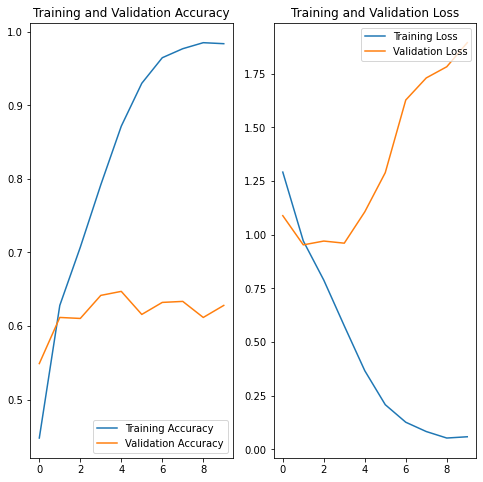

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

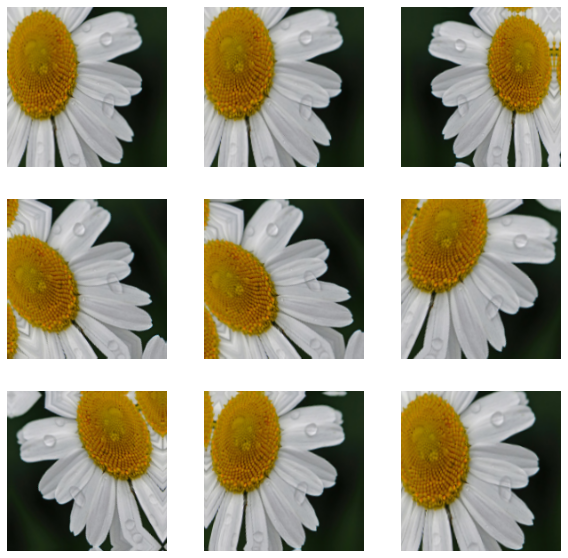

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         


 2D)                                                             


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


 1/92 [..............................] - ETA: 1:43 - loss: 1.6054 - accuracy: 0.1250

 3/92 [..............................] - ETA: 2s - loss: 3.4309 - accuracy: 0.1667  

 5/92 [>.............................] - ETA: 2s - loss: 3.2728 - accuracy: 0.2250

 7/92 [=>............................] - ETA: 2s - loss: 2.8901 - accuracy: 0.2411

 9/92 [=>............................] - ETA: 2s - loss: 2.6093 - accuracy: 0.2431

11/92 [==>...........................] - ETA: 2s - loss: 2.4273 - accuracy: 0.2415

13/92 [===>..........................] - ETA: 2s - loss: 2.2975 - accuracy: 0.2548

15/92 [===>..........................] - ETA: 2s - loss: 2.2042 - accuracy: 0.2625

17/92 [====>.........................] - ETA: 2s - loss: 2.1284 - accuracy: 0.2721

19/92 [=====>........................] - ETA: 2s - loss: 2.0704 - accuracy: 0.2812

21/92 [=====>........................] - ETA: 1s - loss: 2.0210 - accuracy: 0.2753

23/92 [======>.......................] - ETA: 1s - loss: 1.9792 - accuracy: 0.2717

25/92 [=======>......................] - ETA: 1s - loss: 1.9422 - accuracy: 0.2713

27/92 [=======>......................] - ETA: 1s - loss: 1.9125 - accuracy: 0.2731

29/92 [========>.....................] - ETA: 1s - loss: 1.8808 - accuracy: 0.2759

32/92 [=========>....................] - ETA: 1s - loss: 1.8412 - accuracy: 0.2854

34/92 [==========>...................] - ETA: 1s - loss: 1.8172 - accuracy: 0.2898

36/92 [==========>...................] - ETA: 1s - loss: 1.7960 - accuracy: 0.2937

38/92 [===========>..................] - ETA: 1s - loss: 1.7765 - accuracy: 0.2988

40/92 [============>.................] - ETA: 1s - loss: 1.7541 - accuracy: 0.3019

42/92 [============>.................] - ETA: 1s - loss: 1.7414 - accuracy: 0.3046

44/92 [=============>................] - ETA: 1s - loss: 1.7240 - accuracy: 0.3114

46/92 [==============>...............] - ETA: 1s - loss: 1.7082 - accuracy: 0.3142

48/92 [==============>...............] - ETA: 1s - loss: 1.6937 - accuracy: 0.3154

50/92 [===============>..............] - ETA: 1s - loss: 1.6777 - accuracy: 0.3216

52/92 [===============>..............] - ETA: 1s - loss: 1.6594 - accuracy: 0.3267

54/92 [================>.............] - ETA: 1s - loss: 1.6461 - accuracy: 0.3291

56/92 [=================>............] - ETA: 0s - loss: 1.6291 - accuracy: 0.3363

58/92 [=================>............] - ETA: 0s - loss: 1.6161 - accuracy: 0.3404

60/92 [==================>...........] - ETA: 0s - loss: 1.6083 - accuracy: 0.3410

62/92 [===================>..........] - ETA: 0s - loss: 1.6003 - accuracy: 0.3431

64/92 [===================>..........] - ETA: 0s - loss: 1.5895 - accuracy: 0.3495

66/92 [====================>.........] - ETA: 0s - loss: 1.5778 - accuracy: 0.3550

68/92 [=====================>........] - ETA: 0s - loss: 1.5650 - accuracy: 0.3593

70/92 [=====================>........] - ETA: 0s - loss: 1.5519 - accuracy: 0.3638

72/92 [======================>.......] - ETA: 0s - loss: 1.5422 - accuracy: 0.3680

74/92 [=======================>......] - ETA: 0s - loss: 1.5340 - accuracy: 0.3691

76/92 [=======================>......] - ETA: 0s - loss: 1.5280 - accuracy: 0.3692

78/92 [========================>.....] - ETA: 0s - loss: 1.5154 - accuracy: 0.3750

80/92 [=========================>....] - ETA: 0s - loss: 1.5063 - accuracy: 0.3766

82/92 [=========================>....] - ETA: 0s - loss: 1.5010 - accuracy: 0.3792

84/92 [==========================>...] - ETA: 0s - loss: 1.4937 - accuracy: 0.3813

86/92 [===========================>..] - ETA: 0s - loss: 1.4859 - accuracy: 0.3859

88/92 [===========================>..] - ETA: 0s - loss: 1.4814 - accuracy: 0.3868

90/92 [============================>.] - ETA: 0s - loss: 1.4767 - accuracy: 0.3896

92/92 [==============================] - ETA: 0s - loss: 1.4681 - accuracy: 0.3931

92/92 [==============================] - 4s 30ms/step - loss: 1.4681 - accuracy: 0.3931 - val_loss: 1.1181 - val_accuracy: 0.5272


Epoch 2/15


 1/92 [..............................] - ETA: 2s - loss: 0.9906 - accuracy: 0.5312

 4/92 [>.............................] - ETA: 2s - loss: 1.0984 - accuracy: 0.5000

 6/92 [>.............................] - ETA: 2s - loss: 1.0787 - accuracy: 0.5272

 8/92 [=>............................] - ETA: 2s - loss: 1.1121 - accuracy: 0.5363

10/92 [==>...........................] - ETA: 2s - loss: 1.1581 - accuracy: 0.5224

12/92 [==>...........................] - ETA: 2s - loss: 1.1576 - accuracy: 0.5160

14/92 [===>..........................] - ETA: 1s - loss: 1.1511 - accuracy: 0.5205

16/92 [====>.........................] - ETA: 1s - loss: 1.1302 - accuracy: 0.5298

18/92 [====>.........................] - ETA: 1s - loss: 1.1319 - accuracy: 0.5317

20/92 [=====>........................] - ETA: 1s - loss: 1.1322 - accuracy: 0.5301

22/92 [======>.......................] - ETA: 1s - loss: 1.1280 - accuracy: 0.5287

24/92 [======>.......................] - ETA: 1s - loss: 1.1209 - accuracy: 0.5276

26/92 [=======>......................] - ETA: 1s - loss: 1.1201 - accuracy: 0.5328

28/92 [========>.....................] - ETA: 1s - loss: 1.1323 - accuracy: 0.5225

30/92 [========>.....................] - ETA: 1s - loss: 1.1267 - accuracy: 0.5273

32/92 [=========>....................] - ETA: 1s - loss: 1.1213 - accuracy: 0.5325

34/92 [==========>...................] - ETA: 1s - loss: 1.1202 - accuracy: 0.5361

36/92 [==========>...................] - ETA: 1s - loss: 1.1280 - accuracy: 0.5367

38/92 [===========>..................] - ETA: 1s - loss: 1.1177 - accuracy: 0.5406

40/92 [============>.................] - ETA: 1s - loss: 1.1179 - accuracy: 0.5409

42/92 [============>.................] - ETA: 1s - loss: 1.1189 - accuracy: 0.5412

44/92 [=============>................] - ETA: 1s - loss: 1.1106 - accuracy: 0.5436

46/92 [==============>...............] - ETA: 1s - loss: 1.1158 - accuracy: 0.5423

48/92 [==============>...............] - ETA: 1s - loss: 1.1115 - accuracy: 0.5465

50/92 [===============>..............] - ETA: 1s - loss: 1.1131 - accuracy: 0.5452

52/92 [===============>..............] - ETA: 1s - loss: 1.1189 - accuracy: 0.5423

54/92 [================>.............] - ETA: 0s - loss: 1.1235 - accuracy: 0.5407

56/92 [=================>............] - ETA: 0s - loss: 1.1255 - accuracy: 0.5381

58/92 [=================>............] - ETA: 0s - loss: 1.1284 - accuracy: 0.5363

60/92 [==================>...........] - ETA: 0s - loss: 1.1233 - accuracy: 0.5377

62/92 [===================>..........] - ETA: 0s - loss: 1.1218 - accuracy: 0.5369

64/92 [===================>..........] - ETA: 0s - loss: 1.1191 - accuracy: 0.5387

66/92 [====================>.........] - ETA: 0s - loss: 1.1193 - accuracy: 0.5399

68/92 [=====================>........] - ETA: 0s - loss: 1.1132 - accuracy: 0.5434

70/92 [=====================>........] - ETA: 0s - loss: 1.1102 - accuracy: 0.5448

72/92 [======================>.......] - ETA: 0s - loss: 1.1087 - accuracy: 0.5440

74/92 [=======================>......] - ETA: 0s - loss: 1.1151 - accuracy: 0.5415

76/92 [=======================>......] - ETA: 0s - loss: 1.1171 - accuracy: 0.5404

78/92 [========================>.....] - ETA: 0s - loss: 1.1142 - accuracy: 0.5418

80/92 [=========================>....] - ETA: 0s - loss: 1.1097 - accuracy: 0.5435

82/92 [=========================>....] - ETA: 0s - loss: 1.1091 - accuracy: 0.5455

84/92 [==========================>...] - ETA: 0s - loss: 1.1069 - accuracy: 0.5478

86/92 [===========================>..] - ETA: 0s - loss: 1.1028 - accuracy: 0.5485

88/92 [===========================>..] - ETA: 0s - loss: 1.1043 - accuracy: 0.5499

90/92 [============================>.] - ETA: 0s - loss: 1.1031 - accuracy: 0.5512

92/92 [==============================] - ETA: 0s - loss: 1.1017 - accuracy: 0.5504

92/92 [==============================] - 3s 28ms/step - loss: 1.1017 - accuracy: 0.5504 - val_loss: 1.0365 - val_accuracy: 0.5913


Epoch 3/15


 1/92 [..............................] - ETA: 2s - loss: 1.0021 - accuracy: 0.6250

 3/92 [..............................] - ETA: 2s - loss: 1.0934 - accuracy: 0.5833

 5/92 [>.............................] - ETA: 2s - loss: 1.0951 - accuracy: 0.5688

 7/92 [=>............................] - ETA: 2s - loss: 1.0422 - accuracy: 0.6116

 9/92 [=>............................] - ETA: 2s - loss: 1.0105 - accuracy: 0.6146

11/92 [==>...........................] - ETA: 2s - loss: 1.0032 - accuracy: 0.6136

13/92 [===>..........................] - ETA: 2s - loss: 0.9789 - accuracy: 0.6250

15/92 [===>..........................] - ETA: 1s - loss: 0.9867 - accuracy: 0.6229

17/92 [====>.........................] - ETA: 1s - loss: 0.9840 - accuracy: 0.6158

20/92 [=====>........................] - ETA: 1s - loss: 0.9982 - accuracy: 0.6123

22/92 [======>.......................] - ETA: 1s - loss: 1.0098 - accuracy: 0.6020

24/92 [======>.......................] - ETA: 1s - loss: 1.0079 - accuracy: 0.5987

26/92 [=======>......................] - ETA: 1s - loss: 1.0376 - accuracy: 0.5862

28/92 [========>.....................] - ETA: 1s - loss: 1.0424 - accuracy: 0.5800

30/92 [========>.....................] - ETA: 1s - loss: 1.0303 - accuracy: 0.5872

32/92 [=========>....................] - ETA: 1s - loss: 1.0293 - accuracy: 0.5896

34/92 [==========>...................] - ETA: 1s - loss: 1.0374 - accuracy: 0.5824

36/92 [==========>...................] - ETA: 1s - loss: 1.0463 - accuracy: 0.5743

38/92 [===========>..................] - ETA: 1s - loss: 1.0425 - accuracy: 0.5786

40/92 [============>.................] - ETA: 1s - loss: 1.0433 - accuracy: 0.5818

42/92 [============>.................] - ETA: 1s - loss: 1.0514 - accuracy: 0.5778

44/92 [=============>................] - ETA: 1s - loss: 1.0529 - accuracy: 0.5786

46/92 [==============>...............] - ETA: 1s - loss: 1.0604 - accuracy: 0.5751

48/92 [==============>...............] - ETA: 1s - loss: 1.0624 - accuracy: 0.5720

50/92 [===============>..............] - ETA: 1s - loss: 1.0602 - accuracy: 0.5722

52/92 [===============>..............] - ETA: 1s - loss: 1.0609 - accuracy: 0.5731

54/92 [================>.............] - ETA: 0s - loss: 1.0572 - accuracy: 0.5756

56/92 [=================>............] - ETA: 0s - loss: 1.0539 - accuracy: 0.5785

58/92 [=================>............] - ETA: 0s - loss: 1.0525 - accuracy: 0.5801

60/92 [==================>...........] - ETA: 0s - loss: 1.0464 - accuracy: 0.5826

62/92 [===================>..........] - ETA: 0s - loss: 1.0460 - accuracy: 0.5830

64/92 [===================>..........] - ETA: 0s - loss: 1.0425 - accuracy: 0.5853

66/92 [====================>.........] - ETA: 0s - loss: 1.0397 - accuracy: 0.5884

68/92 [=====================>........] - ETA: 0s - loss: 1.0377 - accuracy: 0.5886

70/92 [=====================>........] - ETA: 0s - loss: 1.0466 - accuracy: 0.5856

72/92 [======================>.......] - ETA: 0s - loss: 1.0443 - accuracy: 0.5862

74/92 [=======================>......] - ETA: 0s - loss: 1.0447 - accuracy: 0.5873

76/92 [=======================>......] - ETA: 0s - loss: 1.0421 - accuracy: 0.5895

78/92 [========================>.....] - ETA: 0s - loss: 1.0432 - accuracy: 0.5884

80/92 [=========================>....] - ETA: 0s - loss: 1.0403 - accuracy: 0.5913

82/92 [=========================>....] - ETA: 0s - loss: 1.0378 - accuracy: 0.5925

84/92 [==========================>...] - ETA: 0s - loss: 1.0409 - accuracy: 0.5914

86/92 [===========================>..] - ETA: 0s - loss: 1.0413 - accuracy: 0.5918

88/92 [===========================>..] - ETA: 0s - loss: 1.0415 - accuracy: 0.5919

90/92 [============================>.] - ETA: 0s - loss: 1.0402 - accuracy: 0.5923

92/92 [==============================] - ETA: 0s - loss: 1.0359 - accuracy: 0.5943

92/92 [==============================] - 3s 28ms/step - loss: 1.0359 - accuracy: 0.5943 - val_loss: 1.0137 - val_accuracy: 0.6104


Epoch 4/15


 1/92 [..............................] - ETA: 2s - loss: 0.7973 - accuracy: 0.6875

 3/92 [..............................] - ETA: 2s - loss: 0.8204 - accuracy: 0.6979

 5/92 [>.............................] - ETA: 2s - loss: 0.8604 - accuracy: 0.6500

 7/92 [=>............................] - ETA: 2s - loss: 0.9095 - accuracy: 0.6205

 9/92 [=>............................] - ETA: 2s - loss: 0.9190 - accuracy: 0.6285

11/92 [==>...........................] - ETA: 2s - loss: 0.9143 - accuracy: 0.6364

14/92 [===>..........................] - ETA: 1s - loss: 0.9107 - accuracy: 0.6341

16/92 [====>.........................] - ETA: 1s - loss: 0.9054 - accuracy: 0.6270

18/92 [====>.........................] - ETA: 1s - loss: 0.9257 - accuracy: 0.6215

20/92 [=====>........................] - ETA: 1s - loss: 0.9231 - accuracy: 0.6187

22/92 [======>.......................] - ETA: 1s - loss: 0.9368 - accuracy: 0.6236

24/92 [======>.......................] - ETA: 1s - loss: 0.9390 - accuracy: 0.6276

26/92 [=======>......................] - ETA: 1s - loss: 0.9453 - accuracy: 0.6286

28/92 [========>.....................] - ETA: 1s - loss: 0.9438 - accuracy: 0.6363

30/92 [========>.....................] - ETA: 1s - loss: 0.9421 - accuracy: 0.6366

32/92 [=========>....................] - ETA: 1s - loss: 0.9422 - accuracy: 0.6319

34/92 [==========>...................] - ETA: 1s - loss: 0.9404 - accuracy: 0.6333

36/92 [==========>...................] - ETA: 1s - loss: 0.9405 - accuracy: 0.6381

38/92 [===========>..................] - ETA: 1s - loss: 0.9483 - accuracy: 0.6316

40/92 [============>.................] - ETA: 1s - loss: 0.9483 - accuracy: 0.6305

42/92 [============>.................] - ETA: 1s - loss: 0.9447 - accuracy: 0.6317

44/92 [=============>................] - ETA: 1s - loss: 0.9465 - accuracy: 0.6329

46/92 [==============>...............] - ETA: 1s - loss: 0.9557 - accuracy: 0.6298

48/92 [==============>...............] - ETA: 1s - loss: 0.9564 - accuracy: 0.6302

50/92 [===============>..............] - ETA: 1s - loss: 0.9610 - accuracy: 0.6281

52/92 [===============>..............] - ETA: 1s - loss: 0.9579 - accuracy: 0.6316

54/92 [================>.............] - ETA: 1s - loss: 0.9536 - accuracy: 0.6326

56/92 [=================>............] - ETA: 0s - loss: 0.9580 - accuracy: 0.6323

58/92 [=================>............] - ETA: 0s - loss: 0.9610 - accuracy: 0.6320

60/92 [==================>...........] - ETA: 0s - loss: 0.9567 - accuracy: 0.6339

62/92 [===================>..........] - ETA: 0s - loss: 0.9547 - accuracy: 0.6351

64/92 [===================>..........] - ETA: 0s - loss: 0.9560 - accuracy: 0.6348

66/92 [====================>.........] - ETA: 0s - loss: 0.9544 - accuracy: 0.6359

68/92 [=====================>........] - ETA: 0s - loss: 0.9470 - accuracy: 0.6375

70/92 [=====================>........] - ETA: 0s - loss: 0.9473 - accuracy: 0.6371

72/92 [======================>.......] - ETA: 0s - loss: 0.9466 - accuracy: 0.6381

74/92 [=======================>......] - ETA: 0s - loss: 0.9444 - accuracy: 0.6386

76/92 [=======================>......] - ETA: 0s - loss: 0.9419 - accuracy: 0.6382

78/92 [========================>.....] - ETA: 0s - loss: 0.9402 - accuracy: 0.6383

80/92 [=========================>....] - ETA: 0s - loss: 0.9382 - accuracy: 0.6387

82/92 [=========================>....] - ETA: 0s - loss: 0.9356 - accuracy: 0.6384

84/92 [==========================>...] - ETA: 0s - loss: 0.9348 - accuracy: 0.6392

86/92 [===========================>..] - ETA: 0s - loss: 0.9337 - accuracy: 0.6410

88/92 [===========================>..] - ETA: 0s - loss: 0.9316 - accuracy: 0.6414

90/92 [============================>.] - ETA: 0s - loss: 0.9315 - accuracy: 0.6400

92/92 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.6410

92/92 [==============================] - 3s 29ms/step - loss: 0.9272 - accuracy: 0.6410 - val_loss: 0.8631 - val_accuracy: 0.6662


Epoch 5/15


 1/92 [..............................] - ETA: 2s - loss: 0.7725 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.7248 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 2s - loss: 0.7312 - accuracy: 0.7125

 7/92 [=>............................] - ETA: 2s - loss: 0.7408 - accuracy: 0.7143

 9/92 [=>............................] - ETA: 2s - loss: 0.7381 - accuracy: 0.7326

11/92 [==>...........................] - ETA: 2s - loss: 0.7396 - accuracy: 0.7301

13/92 [===>..........................] - ETA: 2s - loss: 0.7454 - accuracy: 0.7284

15/92 [===>..........................] - ETA: 2s - loss: 0.7630 - accuracy: 0.7083

17/92 [====>.........................] - ETA: 2s - loss: 0.7615 - accuracy: 0.7077

19/92 [=====>........................] - ETA: 1s - loss: 0.7730 - accuracy: 0.7023

21/92 [=====>........................] - ETA: 1s - loss: 0.7923 - accuracy: 0.6949

23/92 [======>.......................] - ETA: 1s - loss: 0.7966 - accuracy: 0.6943

25/92 [=======>......................] - ETA: 1s - loss: 0.8145 - accuracy: 0.6888

27/92 [=======>......................] - ETA: 1s - loss: 0.8243 - accuracy: 0.6863

29/92 [========>.....................] - ETA: 1s - loss: 0.8278 - accuracy: 0.6843

31/92 [=========>....................] - ETA: 1s - loss: 0.8280 - accuracy: 0.6845

33/92 [=========>....................] - ETA: 1s - loss: 0.8320 - accuracy: 0.6837

35/92 [==========>...................] - ETA: 1s - loss: 0.8427 - accuracy: 0.6777

37/92 [===========>..................] - ETA: 1s - loss: 0.8396 - accuracy: 0.6774

39/92 [===========>..................] - ETA: 1s - loss: 0.8442 - accuracy: 0.6763

41/92 [============>.................] - ETA: 1s - loss: 0.8356 - accuracy: 0.6768

43/92 [=============>................] - ETA: 1s - loss: 0.8367 - accuracy: 0.6773

45/92 [=============>................] - ETA: 1s - loss: 0.8367 - accuracy: 0.6792

47/92 [==============>...............] - ETA: 1s - loss: 0.8337 - accuracy: 0.6802

49/92 [==============>...............] - ETA: 1s - loss: 0.8347 - accuracy: 0.6779

51/92 [===============>..............] - ETA: 1s - loss: 0.8365 - accuracy: 0.6771

53/92 [================>.............] - ETA: 1s - loss: 0.8391 - accuracy: 0.6751

55/92 [================>.............] - ETA: 0s - loss: 0.8494 - accuracy: 0.6716

57/92 [=================>............] - ETA: 0s - loss: 0.8461 - accuracy: 0.6738

59/92 [==================>...........] - ETA: 0s - loss: 0.8468 - accuracy: 0.6732

61/92 [==================>...........] - ETA: 0s - loss: 0.8475 - accuracy: 0.6711

63/92 [===================>..........] - ETA: 0s - loss: 0.8509 - accuracy: 0.6716

65/92 [====================>.........] - ETA: 0s - loss: 0.8521 - accuracy: 0.6726

67/92 [====================>.........] - ETA: 0s - loss: 0.8530 - accuracy: 0.6721

69/92 [=====================>........] - ETA: 0s - loss: 0.8484 - accuracy: 0.6744

71/92 [======================>.......] - ETA: 0s - loss: 0.8463 - accuracy: 0.6752

73/92 [======================>.......] - ETA: 0s - loss: 0.8455 - accuracy: 0.6755

75/92 [=======================>......] - ETA: 0s - loss: 0.8454 - accuracy: 0.6767

77/92 [========================>.....] - ETA: 0s - loss: 0.8521 - accuracy: 0.6753

79/92 [========================>.....] - ETA: 0s - loss: 0.8552 - accuracy: 0.6760

82/92 [=========================>....] - ETA: 0s - loss: 0.8555 - accuracy: 0.6751

84/92 [==========================>...] - ETA: 0s - loss: 0.8563 - accuracy: 0.6743

86/92 [===========================>..] - ETA: 0s - loss: 0.8564 - accuracy: 0.6735

88/92 [===========================>..] - ETA: 0s - loss: 0.8576 - accuracy: 0.6734

90/92 [============================>.] - ETA: 0s - loss: 0.8578 - accuracy: 0.6734

92/92 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.6706

92/92 [==============================] - 3s 28ms/step - loss: 0.8648 - accuracy: 0.6706 - val_loss: 0.8629 - val_accuracy: 0.6649


Epoch 6/15


 1/92 [..............................] - ETA: 2s - loss: 0.7165 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.8002 - accuracy: 0.6771

 5/92 [>.............................] - ETA: 2s - loss: 0.7765 - accuracy: 0.7039

 7/92 [=>............................] - ETA: 2s - loss: 0.7315 - accuracy: 0.7176

 9/92 [=>............................] - ETA: 2s - loss: 0.7780 - accuracy: 0.6964

11/92 [==>...........................] - ETA: 2s - loss: 0.7654 - accuracy: 0.7122

13/92 [===>..........................] - ETA: 2s - loss: 0.7798 - accuracy: 0.7083

15/92 [===>..........................] - ETA: 2s - loss: 0.7734 - accuracy: 0.7119

17/92 [====>.........................] - ETA: 2s - loss: 0.8056 - accuracy: 0.6996

19/92 [=====>........................] - ETA: 1s - loss: 0.8102 - accuracy: 0.6983

21/92 [=====>........................] - ETA: 1s - loss: 0.8137 - accuracy: 0.6988

23/92 [======>.......................] - ETA: 1s - loss: 0.8250 - accuracy: 0.6923

25/92 [=======>......................] - ETA: 1s - loss: 0.8304 - accuracy: 0.6932

27/92 [=======>......................] - ETA: 1s - loss: 0.8233 - accuracy: 0.6951

29/92 [========>.....................] - ETA: 1s - loss: 0.8314 - accuracy: 0.6891

31/92 [=========>....................] - ETA: 1s - loss: 0.8421 - accuracy: 0.6819

33/92 [=========>....................] - ETA: 1s - loss: 0.8402 - accuracy: 0.6832

35/92 [==========>...................] - ETA: 1s - loss: 0.8371 - accuracy: 0.6835

37/92 [===========>..................] - ETA: 1s - loss: 0.8412 - accuracy: 0.6828

39/92 [===========>..................] - ETA: 1s - loss: 0.8422 - accuracy: 0.6839

41/92 [============>.................] - ETA: 1s - loss: 0.8502 - accuracy: 0.6794

43/92 [=============>................] - ETA: 1s - loss: 0.8463 - accuracy: 0.6842

45/92 [=============>................] - ETA: 1s - loss: 0.8473 - accuracy: 0.6837

47/92 [==============>...............] - ETA: 1s - loss: 0.8478 - accuracy: 0.6818

49/92 [==============>...............] - ETA: 1s - loss: 0.8490 - accuracy: 0.6827

51/92 [===============>..............] - ETA: 1s - loss: 0.8471 - accuracy: 0.6841

53/92 [================>.............] - ETA: 1s - loss: 0.8482 - accuracy: 0.6836

55/92 [================>.............] - ETA: 1s - loss: 0.8468 - accuracy: 0.6832

57/92 [=================>............] - ETA: 0s - loss: 0.8487 - accuracy: 0.6828

59/92 [==================>...........] - ETA: 0s - loss: 0.8461 - accuracy: 0.6840

61/92 [==================>...........] - ETA: 0s - loss: 0.8461 - accuracy: 0.6836

63/92 [===================>..........] - ETA: 0s - loss: 0.8452 - accuracy: 0.6843

65/92 [====================>.........] - ETA: 0s - loss: 0.8445 - accuracy: 0.6844

67/92 [====================>.........] - ETA: 0s - loss: 0.8370 - accuracy: 0.6868

69/92 [=====================>........] - ETA: 0s - loss: 0.8344 - accuracy: 0.6873

71/92 [======================>.......] - ETA: 0s - loss: 0.8313 - accuracy: 0.6873

73/92 [======================>.......] - ETA: 0s - loss: 0.8337 - accuracy: 0.6847

75/92 [=======================>......] - ETA: 0s - loss: 0.8299 - accuracy: 0.6865

77/92 [========================>.....] - ETA: 0s - loss: 0.8254 - accuracy: 0.6877

79/92 [========================>.....] - ETA: 0s - loss: 0.8221 - accuracy: 0.6885

81/92 [=========================>....] - ETA: 0s - loss: 0.8180 - accuracy: 0.6896

83/92 [==========================>...] - ETA: 0s - loss: 0.8148 - accuracy: 0.6903

85/92 [==========================>...] - ETA: 0s - loss: 0.8174 - accuracy: 0.6884

87/92 [===========================>..] - ETA: 0s - loss: 0.8155 - accuracy: 0.6891

89/92 [============================>.] - ETA: 0s - loss: 0.8123 - accuracy: 0.6912

91/92 [============================>.] - ETA: 0s - loss: 0.8166 - accuracy: 0.6884

92/92 [==============================] - 3s 29ms/step - loss: 0.8158 - accuracy: 0.6887 - val_loss: 0.8362 - val_accuracy: 0.6771


Epoch 7/15


 1/92 [..............................] - ETA: 2s - loss: 0.7669 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.8219 - accuracy: 0.6667

 6/92 [>.............................] - ETA: 2s - loss: 0.7716 - accuracy: 0.6902

 8/92 [=>............................] - ETA: 2s - loss: 0.8444 - accuracy: 0.6694

10/92 [==>...........................] - ETA: 2s - loss: 0.8156 - accuracy: 0.6891

12/92 [==>...........................] - ETA: 2s - loss: 0.7781 - accuracy: 0.6968

14/92 [===>..........................] - ETA: 1s - loss: 0.7722 - accuracy: 0.7023

16/92 [====>.........................] - ETA: 1s - loss: 0.7561 - accuracy: 0.7083

18/92 [====>.........................] - ETA: 1s - loss: 0.7512 - accuracy: 0.7095

20/92 [=====>........................] - ETA: 1s - loss: 0.7654 - accuracy: 0.6994

22/92 [======>.......................] - ETA: 1s - loss: 0.7745 - accuracy: 0.6968

24/92 [======>.......................] - ETA: 1s - loss: 0.7716 - accuracy: 0.7013

26/92 [=======>......................] - ETA: 1s - loss: 0.7736 - accuracy: 0.6966

28/92 [========>.....................] - ETA: 1s - loss: 0.7835 - accuracy: 0.6926

30/92 [========>.....................] - ETA: 1s - loss: 0.7693 - accuracy: 0.6975

32/92 [=========>....................] - ETA: 1s - loss: 0.7757 - accuracy: 0.6969

34/92 [==========>...................] - ETA: 1s - loss: 0.7834 - accuracy: 0.6935

36/92 [==========>...................] - ETA: 1s - loss: 0.7806 - accuracy: 0.6967

38/92 [===========>..................] - ETA: 1s - loss: 0.7837 - accuracy: 0.6937

40/92 [============>.................] - ETA: 1s - loss: 0.7872 - accuracy: 0.6926

42/92 [============>.................] - ETA: 1s - loss: 0.7808 - accuracy: 0.6931

44/92 [=============>................] - ETA: 1s - loss: 0.7851 - accuracy: 0.6943

46/92 [==============>...............] - ETA: 1s - loss: 0.7809 - accuracy: 0.6960

48/92 [==============>...............] - ETA: 1s - loss: 0.7819 - accuracy: 0.6944

50/92 [===============>..............] - ETA: 1s - loss: 0.7821 - accuracy: 0.6947

52/92 [===============>..............] - ETA: 1s - loss: 0.7778 - accuracy: 0.6993

54/92 [================>.............] - ETA: 1s - loss: 0.7782 - accuracy: 0.6994

56/92 [=================>............] - ETA: 0s - loss: 0.7803 - accuracy: 0.6962

58/92 [=================>............] - ETA: 0s - loss: 0.7779 - accuracy: 0.6964

60/92 [==================>...........] - ETA: 0s - loss: 0.7803 - accuracy: 0.6967

62/92 [===================>..........] - ETA: 0s - loss: 0.7822 - accuracy: 0.6964

64/92 [===================>..........] - ETA: 0s - loss: 0.7826 - accuracy: 0.6966

66/92 [====================>.........] - ETA: 0s - loss: 0.7837 - accuracy: 0.6949

68/92 [=====================>........] - ETA: 0s - loss: 0.7805 - accuracy: 0.6960

70/92 [=====================>........] - ETA: 0s - loss: 0.7822 - accuracy: 0.6935

72/92 [======================>.......] - ETA: 0s - loss: 0.7830 - accuracy: 0.6934

74/92 [=======================>......] - ETA: 0s - loss: 0.7858 - accuracy: 0.6907

76/92 [=======================>......] - ETA: 0s - loss: 0.7820 - accuracy: 0.6927

78/92 [========================>.....] - ETA: 0s - loss: 0.7834 - accuracy: 0.6913

80/92 [=========================>....] - ETA: 0s - loss: 0.7822 - accuracy: 0.6936

82/92 [=========================>....] - ETA: 0s - loss: 0.7808 - accuracy: 0.6946

84/92 [==========================>...] - ETA: 0s - loss: 0.7796 - accuracy: 0.6944

86/92 [===========================>..] - ETA: 0s - loss: 0.7776 - accuracy: 0.6957

88/92 [===========================>..] - ETA: 0s - loss: 0.7789 - accuracy: 0.6966

90/92 [============================>.] - ETA: 0s - loss: 0.7795 - accuracy: 0.6967

92/92 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.6962

92/92 [==============================] - 3s 29ms/step - loss: 0.7793 - accuracy: 0.6962 - val_loss: 0.8271 - val_accuracy: 0.6839


Epoch 8/15


 1/92 [..............................] - ETA: 2s - loss: 0.6881 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.8398 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 2s - loss: 0.7604 - accuracy: 0.7000

 7/92 [=>............................] - ETA: 2s - loss: 0.7466 - accuracy: 0.7054

 9/92 [=>............................] - ETA: 2s - loss: 0.7233 - accuracy: 0.7153

11/92 [==>...........................] - ETA: 2s - loss: 0.6956 - accuracy: 0.7244

13/92 [===>..........................] - ETA: 2s - loss: 0.7241 - accuracy: 0.7236

15/92 [===>..........................] - ETA: 2s - loss: 0.7097 - accuracy: 0.7250

17/92 [====>.........................] - ETA: 1s - loss: 0.7152 - accuracy: 0.7206

19/92 [=====>........................] - ETA: 1s - loss: 0.7234 - accuracy: 0.7188

21/92 [=====>........................] - ETA: 1s - loss: 0.7344 - accuracy: 0.7128

23/92 [======>.......................] - ETA: 1s - loss: 0.7345 - accuracy: 0.7160

25/92 [=======>......................] - ETA: 1s - loss: 0.7423 - accuracy: 0.7138

27/92 [=======>......................] - ETA: 1s - loss: 0.7441 - accuracy: 0.7106

29/92 [========>.....................] - ETA: 1s - loss: 0.7610 - accuracy: 0.7047

31/92 [=========>....................] - ETA: 1s - loss: 0.7560 - accuracy: 0.7097

33/92 [=========>....................] - ETA: 1s - loss: 0.7512 - accuracy: 0.7121

35/92 [==========>...................] - ETA: 1s - loss: 0.7505 - accuracy: 0.7125

37/92 [===========>..................] - ETA: 1s - loss: 0.7508 - accuracy: 0.7137

39/92 [===========>..................] - ETA: 1s - loss: 0.7489 - accuracy: 0.7147

41/92 [============>.................] - ETA: 1s - loss: 0.7500 - accuracy: 0.7165

43/92 [=============>................] - ETA: 1s - loss: 0.7442 - accuracy: 0.7188

45/92 [=============>................] - ETA: 1s - loss: 0.7441 - accuracy: 0.7167

47/92 [==============>...............] - ETA: 1s - loss: 0.7455 - accuracy: 0.7154

49/92 [==============>...............] - ETA: 1s - loss: 0.7502 - accuracy: 0.7143

51/92 [===============>..............] - ETA: 1s - loss: 0.7527 - accuracy: 0.7102

53/92 [================>.............] - ETA: 1s - loss: 0.7511 - accuracy: 0.7117

55/92 [================>.............] - ETA: 0s - loss: 0.7462 - accuracy: 0.7142

57/92 [=================>............] - ETA: 0s - loss: 0.7474 - accuracy: 0.7122

59/92 [==================>...........] - ETA: 0s - loss: 0.7463 - accuracy: 0.7119

61/92 [==================>...........] - ETA: 0s - loss: 0.7436 - accuracy: 0.7136

63/92 [===================>..........] - ETA: 0s - loss: 0.7484 - accuracy: 0.7118

65/92 [====================>.........] - ETA: 0s - loss: 0.7464 - accuracy: 0.7130

67/92 [====================>.........] - ETA: 0s - loss: 0.7412 - accuracy: 0.7164

69/92 [=====================>........] - ETA: 0s - loss: 0.7384 - accuracy: 0.7174

71/92 [======================>.......] - ETA: 0s - loss: 0.7353 - accuracy: 0.7205

73/92 [======================>.......] - ETA: 0s - loss: 0.7396 - accuracy: 0.7175

75/92 [=======================>......] - ETA: 0s - loss: 0.7375 - accuracy: 0.7200

77/92 [========================>.....] - ETA: 0s - loss: 0.7377 - accuracy: 0.7196

79/92 [========================>.....] - ETA: 0s - loss: 0.7379 - accuracy: 0.7199

81/92 [=========================>....] - ETA: 0s - loss: 0.7336 - accuracy: 0.7218

83/92 [==========================>...] - ETA: 0s - loss: 0.7322 - accuracy: 0.7214

86/92 [===========================>..] - ETA: 0s - loss: 0.7294 - accuracy: 0.7230

88/92 [===========================>..] - ETA: 0s - loss: 0.7317 - accuracy: 0.7204

90/92 [============================>.] - ETA: 0s - loss: 0.7319 - accuracy: 0.7204

92/92 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7214

92/92 [==============================] - 3s 28ms/step - loss: 0.7310 - accuracy: 0.7214 - val_loss: 0.8039 - val_accuracy: 0.7003


Epoch 9/15


 1/92 [..............................] - ETA: 2s - loss: 0.9164 - accuracy: 0.6250

 3/92 [..............................] - ETA: 2s - loss: 0.8203 - accuracy: 0.6562

 5/92 [>.............................] - ETA: 2s - loss: 0.7765 - accuracy: 0.7063

 7/92 [=>............................] - ETA: 2s - loss: 0.7802 - accuracy: 0.6920

 9/92 [=>............................] - ETA: 2s - loss: 0.7328 - accuracy: 0.7118

11/92 [==>...........................] - ETA: 2s - loss: 0.7111 - accuracy: 0.7273

13/92 [===>..........................] - ETA: 2s - loss: 0.7074 - accuracy: 0.7260

15/92 [===>..........................] - ETA: 1s - loss: 0.6813 - accuracy: 0.7417

18/92 [====>.........................] - ETA: 1s - loss: 0.6931 - accuracy: 0.7394

20/92 [=====>........................] - ETA: 1s - loss: 0.6851 - accuracy: 0.7405

22/92 [======>.......................] - ETA: 1s - loss: 0.6871 - accuracy: 0.7399

24/92 [======>.......................] - ETA: 1s - loss: 0.6938 - accuracy: 0.7382

26/92 [=======>......................] - ETA: 1s - loss: 0.7029 - accuracy: 0.7367

28/92 [========>.....................] - ETA: 1s - loss: 0.6936 - accuracy: 0.7410

30/92 [========>.....................] - ETA: 1s - loss: 0.6904 - accuracy: 0.7458

32/92 [=========>....................] - ETA: 1s - loss: 0.6964 - accuracy: 0.7441

34/92 [==========>...................] - ETA: 1s - loss: 0.7063 - accuracy: 0.7361

36/92 [==========>...................] - ETA: 1s - loss: 0.7067 - accuracy: 0.7343

38/92 [===========>..................] - ETA: 1s - loss: 0.7230 - accuracy: 0.7285

40/92 [============>.................] - ETA: 1s - loss: 0.7300 - accuracy: 0.7272

42/92 [============>.................] - ETA: 1s - loss: 0.7235 - accuracy: 0.7283

44/92 [=============>................] - ETA: 1s - loss: 0.7250 - accuracy: 0.7257

46/92 [==============>...............] - ETA: 1s - loss: 0.7193 - accuracy: 0.7281

48/92 [==============>...............] - ETA: 1s - loss: 0.7226 - accuracy: 0.7271

50/92 [===============>..............] - ETA: 1s - loss: 0.7227 - accuracy: 0.7261

52/92 [===============>..............] - ETA: 1s - loss: 0.7212 - accuracy: 0.7264

54/92 [================>.............] - ETA: 0s - loss: 0.7274 - accuracy: 0.7256

56/92 [=================>............] - ETA: 0s - loss: 0.7271 - accuracy: 0.7253

58/92 [=================>............] - ETA: 0s - loss: 0.7289 - accuracy: 0.7256

60/92 [==================>...........] - ETA: 0s - loss: 0.7272 - accuracy: 0.7275

62/92 [===================>..........] - ETA: 0s - loss: 0.7291 - accuracy: 0.7267

64/92 [===================>..........] - ETA: 0s - loss: 0.7308 - accuracy: 0.7270

66/92 [====================>.........] - ETA: 0s - loss: 0.7263 - accuracy: 0.7277

68/92 [=====================>........] - ETA: 0s - loss: 0.7240 - accuracy: 0.7288

70/92 [=====================>........] - ETA: 0s - loss: 0.7244 - accuracy: 0.7272

72/92 [======================>.......] - ETA: 0s - loss: 0.7226 - accuracy: 0.7282

74/92 [=======================>......] - ETA: 0s - loss: 0.7270 - accuracy: 0.7267

76/92 [=======================>......] - ETA: 0s - loss: 0.7279 - accuracy: 0.7269

78/92 [========================>.....] - ETA: 0s - loss: 0.7257 - accuracy: 0.7283

80/92 [=========================>....] - ETA: 0s - loss: 0.7270 - accuracy: 0.7284

82/92 [=========================>....] - ETA: 0s - loss: 0.7266 - accuracy: 0.7263

84/92 [==========================>...] - ETA: 0s - loss: 0.7261 - accuracy: 0.7276

86/92 [===========================>..] - ETA: 0s - loss: 0.7233 - accuracy: 0.7281

88/92 [===========================>..] - ETA: 0s - loss: 0.7230 - accuracy: 0.7283

90/92 [============================>.] - ETA: 0s - loss: 0.7242 - accuracy: 0.7270

92/92 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.7275

92/92 [==============================] - 3s 28ms/step - loss: 0.7222 - accuracy: 0.7275 - val_loss: 0.7739 - val_accuracy: 0.6921


Epoch 10/15


 1/92 [..............................] - ETA: 2s - loss: 0.7813 - accuracy: 0.6250

 3/92 [..............................] - ETA: 2s - loss: 0.7006 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 2s - loss: 0.6580 - accuracy: 0.7375

 7/92 [=>............................] - ETA: 2s - loss: 0.6446 - accuracy: 0.7455

 9/92 [=>............................] - ETA: 2s - loss: 0.6168 - accuracy: 0.7639

12/92 [==>...........................] - ETA: 2s - loss: 0.6088 - accuracy: 0.7686

14/92 [===>..........................] - ETA: 2s - loss: 0.6107 - accuracy: 0.7682

16/92 [====>.........................] - ETA: 1s - loss: 0.6132 - accuracy: 0.7718

18/92 [====>.........................] - ETA: 1s - loss: 0.6205 - accuracy: 0.7782

20/92 [=====>........................] - ETA: 1s - loss: 0.6140 - accuracy: 0.7816

22/92 [======>.......................] - ETA: 1s - loss: 0.6213 - accuracy: 0.7759

24/92 [======>.......................] - ETA: 1s - loss: 0.6199 - accuracy: 0.7724

26/92 [=======>......................] - ETA: 1s - loss: 0.6227 - accuracy: 0.7694

28/92 [========>.....................] - ETA: 1s - loss: 0.6293 - accuracy: 0.7669

30/92 [========>.....................] - ETA: 1s - loss: 0.6325 - accuracy: 0.7668

32/92 [=========>....................] - ETA: 1s - loss: 0.6360 - accuracy: 0.7667

34/92 [==========>...................] - ETA: 1s - loss: 0.6513 - accuracy: 0.7611

36/92 [==========>...................] - ETA: 1s - loss: 0.6502 - accuracy: 0.7622

38/92 [===========>..................] - ETA: 1s - loss: 0.6487 - accuracy: 0.7616

40/92 [============>.................] - ETA: 1s - loss: 0.6621 - accuracy: 0.7555

42/92 [============>.................] - ETA: 1s - loss: 0.6643 - accuracy: 0.7522

44/92 [=============>................] - ETA: 1s - loss: 0.6655 - accuracy: 0.7500

46/92 [==============>...............] - ETA: 1s - loss: 0.6702 - accuracy: 0.7473

48/92 [==============>...............] - ETA: 1s - loss: 0.6655 - accuracy: 0.7493

50/92 [===============>..............] - ETA: 1s - loss: 0.6672 - accuracy: 0.7494

52/92 [===============>..............] - ETA: 1s - loss: 0.6692 - accuracy: 0.7482

54/92 [================>.............] - ETA: 0s - loss: 0.6693 - accuracy: 0.7471

56/92 [=================>............] - ETA: 0s - loss: 0.6715 - accuracy: 0.7466

58/92 [=================>............] - ETA: 0s - loss: 0.6699 - accuracy: 0.7484

60/92 [==================>...........] - ETA: 0s - loss: 0.6691 - accuracy: 0.7510

62/92 [===================>..........] - ETA: 0s - loss: 0.6746 - accuracy: 0.7490

64/92 [===================>..........] - ETA: 0s - loss: 0.6708 - accuracy: 0.7495

66/92 [====================>.........] - ETA: 0s - loss: 0.6701 - accuracy: 0.7505

68/92 [=====================>........] - ETA: 0s - loss: 0.6716 - accuracy: 0.7500

70/92 [=====================>........] - ETA: 0s - loss: 0.6721 - accuracy: 0.7509

72/92 [======================>.......] - ETA: 0s - loss: 0.6717 - accuracy: 0.7496

74/92 [=======================>......] - ETA: 0s - loss: 0.6698 - accuracy: 0.7500

76/92 [=======================>......] - ETA: 0s - loss: 0.6681 - accuracy: 0.7508

78/92 [========================>.....] - ETA: 0s - loss: 0.6692 - accuracy: 0.7512

80/92 [=========================>....] - ETA: 0s - loss: 0.6674 - accuracy: 0.7524

82/92 [=========================>....] - ETA: 0s - loss: 0.6735 - accuracy: 0.7477

84/92 [==========================>...] - ETA: 0s - loss: 0.6722 - accuracy: 0.7478

86/92 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.7467

88/92 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.7450

90/92 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.7465

92/92 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.7466

92/92 [==============================] - 3s 28ms/step - loss: 0.6738 - accuracy: 0.7466 - val_loss: 0.8141 - val_accuracy: 0.6866


Epoch 11/15


 1/92 [..............................] - ETA: 2s - loss: 0.8186 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.6944 - accuracy: 0.7812

 5/92 [>.............................] - ETA: 2s - loss: 0.6726 - accuracy: 0.7563

 7/92 [=>............................] - ETA: 2s - loss: 0.6229 - accuracy: 0.7634

 9/92 [=>............................] - ETA: 2s - loss: 0.6378 - accuracy: 0.7639

12/92 [==>...........................] - ETA: 2s - loss: 0.6604 - accuracy: 0.7420

14/92 [===>..........................] - ETA: 1s - loss: 0.6401 - accuracy: 0.7523

16/92 [====>.........................] - ETA: 1s - loss: 0.6498 - accuracy: 0.7440

18/92 [====>.........................] - ETA: 1s - loss: 0.6662 - accuracy: 0.7430

20/92 [=====>........................] - ETA: 1s - loss: 0.6673 - accuracy: 0.7453

22/92 [======>.......................] - ETA: 1s - loss: 0.6616 - accuracy: 0.7471

24/92 [======>.......................] - ETA: 1s - loss: 0.6548 - accuracy: 0.7487

26/92 [=======>......................] - ETA: 1s - loss: 0.6486 - accuracy: 0.7500

28/92 [========>.....................] - ETA: 1s - loss: 0.6498 - accuracy: 0.7489

30/92 [========>.....................] - ETA: 1s - loss: 0.6570 - accuracy: 0.7437

32/92 [=========>....................] - ETA: 1s - loss: 0.6636 - accuracy: 0.7392

34/92 [==========>...................] - ETA: 1s - loss: 0.6745 - accuracy: 0.7370

36/92 [==========>...................] - ETA: 1s - loss: 0.6696 - accuracy: 0.7421

38/92 [===========>..................] - ETA: 1s - loss: 0.6639 - accuracy: 0.7459

40/92 [============>.................] - ETA: 1s - loss: 0.6626 - accuracy: 0.7453

42/92 [============>.................] - ETA: 1s - loss: 0.6577 - accuracy: 0.7470

44/92 [=============>................] - ETA: 1s - loss: 0.6611 - accuracy: 0.7457

46/92 [==============>...............] - ETA: 1s - loss: 0.6552 - accuracy: 0.7480

48/92 [==============>...............] - ETA: 1s - loss: 0.6607 - accuracy: 0.7474

50/92 [===============>..............] - ETA: 1s - loss: 0.6618 - accuracy: 0.7481

52/92 [===============>..............] - ETA: 1s - loss: 0.6646 - accuracy: 0.7470

54/92 [================>.............] - ETA: 0s - loss: 0.6631 - accuracy: 0.7483

56/92 [=================>............] - ETA: 0s - loss: 0.6614 - accuracy: 0.7500

58/92 [=================>............] - ETA: 0s - loss: 0.6625 - accuracy: 0.7495

60/92 [==================>...........] - ETA: 0s - loss: 0.6663 - accuracy: 0.7479

62/92 [===================>..........] - ETA: 0s - loss: 0.6702 - accuracy: 0.7460

64/92 [===================>..........] - ETA: 0s - loss: 0.6754 - accuracy: 0.7461

66/92 [====================>.........] - ETA: 0s - loss: 0.6789 - accuracy: 0.7448

68/92 [=====================>........] - ETA: 0s - loss: 0.6782 - accuracy: 0.7435

70/92 [=====================>........] - ETA: 0s - loss: 0.6781 - accuracy: 0.7433

72/92 [======================>.......] - ETA: 0s - loss: 0.6741 - accuracy: 0.7448

74/92 [=======================>......] - ETA: 0s - loss: 0.6737 - accuracy: 0.7458

76/92 [=======================>......] - ETA: 0s - loss: 0.6723 - accuracy: 0.7479

78/92 [========================>.....] - ETA: 0s - loss: 0.6668 - accuracy: 0.7508

80/92 [=========================>....] - ETA: 0s - loss: 0.6677 - accuracy: 0.7488

82/92 [=========================>....] - ETA: 0s - loss: 0.6694 - accuracy: 0.7477

84/92 [==========================>...] - ETA: 0s - loss: 0.6686 - accuracy: 0.7470

86/92 [===========================>..] - ETA: 0s - loss: 0.6681 - accuracy: 0.7467

88/92 [===========================>..] - ETA: 0s - loss: 0.6690 - accuracy: 0.7472

90/92 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.7476

92/92 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.7480

92/92 [==============================] - 3s 27ms/step - loss: 0.6683 - accuracy: 0.7480 - val_loss: 0.7524 - val_accuracy: 0.7125


Epoch 12/15


 1/92 [..............................] - ETA: 1s - loss: 0.7128 - accuracy: 0.7083

 3/92 [..............................] - ETA: 2s - loss: 0.7278 - accuracy: 0.6932

 5/92 [>.............................] - ETA: 2s - loss: 0.7868 - accuracy: 0.6579

 7/92 [=>............................] - ETA: 2s - loss: 0.7534 - accuracy: 0.6759

 9/92 [=>............................] - ETA: 2s - loss: 0.7357 - accuracy: 0.6929

11/92 [==>...........................] - ETA: 2s - loss: 0.7246 - accuracy: 0.7093

13/92 [===>..........................] - ETA: 2s - loss: 0.6892 - accuracy: 0.7255

15/92 [===>..........................] - ETA: 2s - loss: 0.6721 - accuracy: 0.7352

17/92 [====>.........................] - ETA: 2s - loss: 0.6742 - accuracy: 0.7351

19/92 [=====>........................] - ETA: 1s - loss: 0.6737 - accuracy: 0.7350

21/92 [=====>........................] - ETA: 1s - loss: 0.6643 - accuracy: 0.7395

23/92 [======>.......................] - ETA: 1s - loss: 0.6634 - accuracy: 0.7404

25/92 [=======>......................] - ETA: 1s - loss: 0.6575 - accuracy: 0.7399

27/92 [=======>......................] - ETA: 1s - loss: 0.6579 - accuracy: 0.7407

29/92 [========>.....................] - ETA: 1s - loss: 0.6419 - accuracy: 0.7489

31/92 [=========>....................] - ETA: 1s - loss: 0.6349 - accuracy: 0.7530

33/92 [=========>....................] - ETA: 1s - loss: 0.6419 - accuracy: 0.7490

35/92 [==========>...................] - ETA: 1s - loss: 0.6505 - accuracy: 0.7437

37/92 [===========>..................] - ETA: 1s - loss: 0.6490 - accuracy: 0.7491

39/92 [===========>..................] - ETA: 1s - loss: 0.6414 - accuracy: 0.7508

41/92 [============>.................] - ETA: 1s - loss: 0.6408 - accuracy: 0.7492

43/92 [=============>................] - ETA: 1s - loss: 0.6350 - accuracy: 0.7500

45/92 [=============>................] - ETA: 1s - loss: 0.6369 - accuracy: 0.7493

47/92 [==============>...............] - ETA: 1s - loss: 0.6323 - accuracy: 0.7520

49/92 [==============>...............] - ETA: 1s - loss: 0.6334 - accuracy: 0.7538

51/92 [===============>..............] - ETA: 1s - loss: 0.6355 - accuracy: 0.7512

53/92 [================>.............] - ETA: 1s - loss: 0.6287 - accuracy: 0.7536

55/92 [================>.............] - ETA: 0s - loss: 0.6256 - accuracy: 0.7540

57/92 [=================>............] - ETA: 0s - loss: 0.6259 - accuracy: 0.7544

59/92 [==================>...........] - ETA: 0s - loss: 0.6249 - accuracy: 0.7543

61/92 [==================>...........] - ETA: 0s - loss: 0.6266 - accuracy: 0.7536

63/92 [===================>..........] - ETA: 0s - loss: 0.6289 - accuracy: 0.7540

65/92 [====================>.........] - ETA: 0s - loss: 0.6314 - accuracy: 0.7529

67/92 [====================>.........] - ETA: 0s - loss: 0.6321 - accuracy: 0.7528

69/92 [=====================>........] - ETA: 0s - loss: 0.6298 - accuracy: 0.7545

71/92 [======================>.......] - ETA: 0s - loss: 0.6322 - accuracy: 0.7553

73/92 [======================>.......] - ETA: 0s - loss: 0.6339 - accuracy: 0.7552

75/92 [=======================>......] - ETA: 0s - loss: 0.6360 - accuracy: 0.7529

77/92 [========================>.....] - ETA: 0s - loss: 0.6371 - accuracy: 0.7520

79/92 [========================>.....] - ETA: 0s - loss: 0.6349 - accuracy: 0.7536

81/92 [=========================>....] - ETA: 0s - loss: 0.6335 - accuracy: 0.7539

83/92 [==========================>...] - ETA: 0s - loss: 0.6349 - accuracy: 0.7519

85/92 [==========================>...] - ETA: 0s - loss: 0.6372 - accuracy: 0.7511

87/92 [===========================>..] - ETA: 0s - loss: 0.6376 - accuracy: 0.7511

89/92 [============================>.] - ETA: 0s - loss: 0.6361 - accuracy: 0.7518

91/92 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.7521

92/92 [==============================] - 3s 28ms/step - loss: 0.6372 - accuracy: 0.7524 - val_loss: 0.7144 - val_accuracy: 0.7248


Epoch 13/15


 1/92 [..............................] - ETA: 2s - loss: 0.7533 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.5992 - accuracy: 0.7917

 5/92 [>.............................] - ETA: 2s - loss: 0.5861 - accuracy: 0.7625

 7/92 [=>............................] - ETA: 2s - loss: 0.5917 - accuracy: 0.7634

 9/92 [=>............................] - ETA: 2s - loss: 0.5762 - accuracy: 0.7674

11/92 [==>...........................] - ETA: 2s - loss: 0.5712 - accuracy: 0.7727

13/92 [===>..........................] - ETA: 2s - loss: 0.5755 - accuracy: 0.7620

15/92 [===>..........................] - ETA: 2s - loss: 0.5787 - accuracy: 0.7688

17/92 [====>.........................] - ETA: 1s - loss: 0.5781 - accuracy: 0.7702

19/92 [=====>........................] - ETA: 1s - loss: 0.5872 - accuracy: 0.7681

22/92 [======>.......................] - ETA: 1s - loss: 0.5842 - accuracy: 0.7672

24/92 [======>.......................] - ETA: 1s - loss: 0.5897 - accuracy: 0.7632

26/92 [=======>......................] - ETA: 1s - loss: 0.6023 - accuracy: 0.7597

28/92 [========>.....................] - ETA: 1s - loss: 0.6001 - accuracy: 0.7590

30/92 [========>.....................] - ETA: 1s - loss: 0.5938 - accuracy: 0.7605

32/92 [=========>....................] - ETA: 1s - loss: 0.5926 - accuracy: 0.7608

34/92 [==========>...................] - ETA: 1s - loss: 0.5950 - accuracy: 0.7657

36/92 [==========>...................] - ETA: 1s - loss: 0.6031 - accuracy: 0.7640

38/92 [===========>..................] - ETA: 1s - loss: 0.6024 - accuracy: 0.7641

40/92 [============>.................] - ETA: 1s - loss: 0.6056 - accuracy: 0.7626

42/92 [============>.................] - ETA: 1s - loss: 0.6027 - accuracy: 0.7642

44/92 [=============>................] - ETA: 1s - loss: 0.6083 - accuracy: 0.7600

46/92 [==============>...............] - ETA: 1s - loss: 0.6067 - accuracy: 0.7616

48/92 [==============>...............] - ETA: 1s - loss: 0.6024 - accuracy: 0.7644

50/92 [===============>..............] - ETA: 1s - loss: 0.6010 - accuracy: 0.7651

52/92 [===============>..............] - ETA: 1s - loss: 0.6010 - accuracy: 0.7639

54/92 [================>.............] - ETA: 0s - loss: 0.6034 - accuracy: 0.7640

56/92 [=================>............] - ETA: 0s - loss: 0.5982 - accuracy: 0.7663

58/92 [=================>............] - ETA: 0s - loss: 0.6000 - accuracy: 0.7657

60/92 [==================>...........] - ETA: 0s - loss: 0.6080 - accuracy: 0.7615

62/92 [===================>..........] - ETA: 0s - loss: 0.6094 - accuracy: 0.7606

64/92 [===================>..........] - ETA: 0s - loss: 0.6087 - accuracy: 0.7618

66/92 [====================>.........] - ETA: 0s - loss: 0.6128 - accuracy: 0.7576

68/92 [=====================>........] - ETA: 0s - loss: 0.6076 - accuracy: 0.7606

70/92 [=====================>........] - ETA: 0s - loss: 0.6116 - accuracy: 0.7599

72/92 [======================>.......] - ETA: 0s - loss: 0.6134 - accuracy: 0.7596

74/92 [=======================>......] - ETA: 0s - loss: 0.6147 - accuracy: 0.7581

76/92 [=======================>......] - ETA: 0s - loss: 0.6166 - accuracy: 0.7562

78/92 [========================>.....] - ETA: 0s - loss: 0.6168 - accuracy: 0.7572

80/92 [=========================>....] - ETA: 0s - loss: 0.6167 - accuracy: 0.7574

82/92 [=========================>....] - ETA: 0s - loss: 0.6171 - accuracy: 0.7561

84/92 [==========================>...] - ETA: 0s - loss: 0.6151 - accuracy: 0.7578

86/92 [===========================>..] - ETA: 0s - loss: 0.6131 - accuracy: 0.7591

88/92 [===========================>..] - ETA: 0s - loss: 0.6136 - accuracy: 0.7589

90/92 [============================>.] - ETA: 0s - loss: 0.6129 - accuracy: 0.7597

92/92 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7575

92/92 [==============================] - 3s 28ms/step - loss: 0.6151 - accuracy: 0.7575 - val_loss: 0.7929 - val_accuracy: 0.6744


Epoch 14/15


 1/92 [..............................] - ETA: 2s - loss: 0.7253 - accuracy: 0.6562

 3/92 [..............................] - ETA: 2s - loss: 0.6676 - accuracy: 0.7083

 5/92 [>.............................] - ETA: 2s - loss: 0.6568 - accuracy: 0.7375

 7/92 [=>............................] - ETA: 2s - loss: 0.6351 - accuracy: 0.7545

 9/92 [=>............................] - ETA: 2s - loss: 0.6090 - accuracy: 0.7639

11/92 [==>...........................] - ETA: 2s - loss: 0.5993 - accuracy: 0.7756

13/92 [===>..........................] - ETA: 2s - loss: 0.5780 - accuracy: 0.7788

15/92 [===>..........................] - ETA: 1s - loss: 0.6077 - accuracy: 0.7646

17/92 [====>.........................] - ETA: 1s - loss: 0.6190 - accuracy: 0.7665

19/92 [=====>........................] - ETA: 1s - loss: 0.6168 - accuracy: 0.7681

21/92 [=====>........................] - ETA: 1s - loss: 0.6149 - accuracy: 0.7634

23/92 [======>.......................] - ETA: 1s - loss: 0.6131 - accuracy: 0.7636

25/92 [=======>......................] - ETA: 1s - loss: 0.6069 - accuracy: 0.7638

27/92 [=======>......................] - ETA: 1s - loss: 0.6028 - accuracy: 0.7662

29/92 [========>.....................] - ETA: 1s - loss: 0.6074 - accuracy: 0.7672

31/92 [=========>....................] - ETA: 1s - loss: 0.6012 - accuracy: 0.7692

33/92 [=========>....................] - ETA: 1s - loss: 0.6058 - accuracy: 0.7689

35/92 [==========>...................] - ETA: 1s - loss: 0.6003 - accuracy: 0.7750

37/92 [===========>..................] - ETA: 1s - loss: 0.6005 - accuracy: 0.7745

39/92 [===========>..................] - ETA: 1s - loss: 0.5974 - accuracy: 0.7756

41/92 [============>.................] - ETA: 1s - loss: 0.5950 - accuracy: 0.7736

44/92 [=============>................] - ETA: 1s - loss: 0.5847 - accuracy: 0.7756

46/92 [==============>...............] - ETA: 1s - loss: 0.5804 - accuracy: 0.7785

48/92 [==============>...............] - ETA: 1s - loss: 0.5792 - accuracy: 0.7793

50/92 [===============>..............] - ETA: 1s - loss: 0.5733 - accuracy: 0.7812

52/92 [===============>..............] - ETA: 1s - loss: 0.5707 - accuracy: 0.7831

54/92 [================>.............] - ETA: 0s - loss: 0.5761 - accuracy: 0.7812

56/92 [=================>............] - ETA: 0s - loss: 0.5716 - accuracy: 0.7846

58/92 [=================>............] - ETA: 0s - loss: 0.5712 - accuracy: 0.7834

60/92 [==================>...........] - ETA: 0s - loss: 0.5716 - accuracy: 0.7833

62/92 [===================>..........] - ETA: 0s - loss: 0.5698 - accuracy: 0.7848

64/92 [===================>..........] - ETA: 0s - loss: 0.5721 - accuracy: 0.7832

66/92 [====================>.........] - ETA: 0s - loss: 0.5688 - accuracy: 0.7850

68/92 [=====================>........] - ETA: 0s - loss: 0.5669 - accuracy: 0.7863

70/92 [=====================>........] - ETA: 0s - loss: 0.5665 - accuracy: 0.7862

72/92 [======================>.......] - ETA: 0s - loss: 0.5687 - accuracy: 0.7847

74/92 [=======================>......] - ETA: 0s - loss: 0.5696 - accuracy: 0.7846

76/92 [=======================>......] - ETA: 0s - loss: 0.5795 - accuracy: 0.7800

78/92 [========================>.....] - ETA: 0s - loss: 0.5808 - accuracy: 0.7800

80/92 [=========================>....] - ETA: 0s - loss: 0.5826 - accuracy: 0.7781

82/92 [=========================>....] - ETA: 0s - loss: 0.5863 - accuracy: 0.7771

84/92 [==========================>...] - ETA: 0s - loss: 0.5852 - accuracy: 0.7779

86/92 [===========================>..] - ETA: 0s - loss: 0.5834 - accuracy: 0.7791

88/92 [===========================>..] - ETA: 0s - loss: 0.5826 - accuracy: 0.7788

91/92 [============================>.] - ETA: 0s - loss: 0.5858 - accuracy: 0.7782

92/92 [==============================] - 3s 28ms/step - loss: 0.5850 - accuracy: 0.7786 - val_loss: 0.7484 - val_accuracy: 0.7234


Epoch 15/15


 1/92 [..............................] - ETA: 2s - loss: 0.4830 - accuracy: 0.8125

 3/92 [..............................] - ETA: 2s - loss: 0.4632 - accuracy: 0.8021

 5/92 [>.............................] - ETA: 2s - loss: 0.5648 - accuracy: 0.7688

 7/92 [=>............................] - ETA: 2s - loss: 0.5570 - accuracy: 0.7812

 9/92 [=>............................] - ETA: 2s - loss: 0.5735 - accuracy: 0.7847

11/92 [==>...........................] - ETA: 2s - loss: 0.5818 - accuracy: 0.7812

13/92 [===>..........................] - ETA: 2s - loss: 0.6027 - accuracy: 0.7788

15/92 [===>..........................] - ETA: 2s - loss: 0.5757 - accuracy: 0.7896

17/92 [====>.........................] - ETA: 2s - loss: 0.5692 - accuracy: 0.7941

19/92 [=====>........................] - ETA: 1s - loss: 0.5574 - accuracy: 0.7977

21/92 [=====>........................] - ETA: 1s - loss: 0.5586 - accuracy: 0.7976

23/92 [======>.......................] - ETA: 1s - loss: 0.5629 - accuracy: 0.7989

25/92 [=======>......................] - ETA: 1s - loss: 0.5595 - accuracy: 0.7987

27/92 [=======>......................] - ETA: 1s - loss: 0.5672 - accuracy: 0.7894

29/92 [========>.....................] - ETA: 1s - loss: 0.5628 - accuracy: 0.7888

31/92 [=========>....................] - ETA: 1s - loss: 0.5688 - accuracy: 0.7903

33/92 [=========>....................] - ETA: 1s - loss: 0.5656 - accuracy: 0.7917

35/92 [==========>...................] - ETA: 1s - loss: 0.5573 - accuracy: 0.7937

37/92 [===========>..................] - ETA: 1s - loss: 0.5492 - accuracy: 0.7973

39/92 [===========>..................] - ETA: 1s - loss: 0.5469 - accuracy: 0.7965

41/92 [============>.................] - ETA: 1s - loss: 0.5414 - accuracy: 0.7995

43/92 [=============>................] - ETA: 1s - loss: 0.5468 - accuracy: 0.7958

45/92 [=============>................] - ETA: 1s - loss: 0.5381 - accuracy: 0.7993

47/92 [==============>...............] - ETA: 1s - loss: 0.5387 - accuracy: 0.7999

49/92 [==============>...............] - ETA: 1s - loss: 0.5379 - accuracy: 0.7991

51/92 [===============>..............] - ETA: 1s - loss: 0.5408 - accuracy: 0.7978

53/92 [================>.............] - ETA: 1s - loss: 0.5454 - accuracy: 0.7948

55/92 [================>.............] - ETA: 0s - loss: 0.5439 - accuracy: 0.7972

57/92 [=================>............] - ETA: 0s - loss: 0.5450 - accuracy: 0.7961

59/92 [==================>...........] - ETA: 0s - loss: 0.5470 - accuracy: 0.7945

61/92 [==================>...........] - ETA: 0s - loss: 0.5521 - accuracy: 0.7925

63/92 [===================>..........] - ETA: 0s - loss: 0.5554 - accuracy: 0.7907

65/92 [====================>.........] - ETA: 0s - loss: 0.5606 - accuracy: 0.7899

67/92 [====================>.........] - ETA: 0s - loss: 0.5639 - accuracy: 0.7887

69/92 [=====================>........] - ETA: 0s - loss: 0.5625 - accuracy: 0.7899

71/92 [======================>.......] - ETA: 0s - loss: 0.5612 - accuracy: 0.7909

73/92 [======================>.......] - ETA: 0s - loss: 0.5609 - accuracy: 0.7928

75/92 [=======================>......] - ETA: 0s - loss: 0.5600 - accuracy: 0.7933

77/92 [========================>.....] - ETA: 0s - loss: 0.5631 - accuracy: 0.7914

79/92 [========================>.....] - ETA: 0s - loss: 0.5574 - accuracy: 0.7927

82/92 [=========================>....] - ETA: 0s - loss: 0.5552 - accuracy: 0.7936

84/92 [==========================>...] - ETA: 0s - loss: 0.5526 - accuracy: 0.7940

86/92 [===========================>..] - ETA: 0s - loss: 0.5538 - accuracy: 0.7923

88/92 [===========================>..] - ETA: 0s - loss: 0.5554 - accuracy: 0.7920

90/92 [============================>.] - ETA: 0s - loss: 0.5523 - accuracy: 0.7932

92/92 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7916

92/92 [==============================] - 3s 28ms/step - loss: 0.5567 - accuracy: 0.7916 - val_loss: 0.8348 - val_accuracy: 0.7057


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

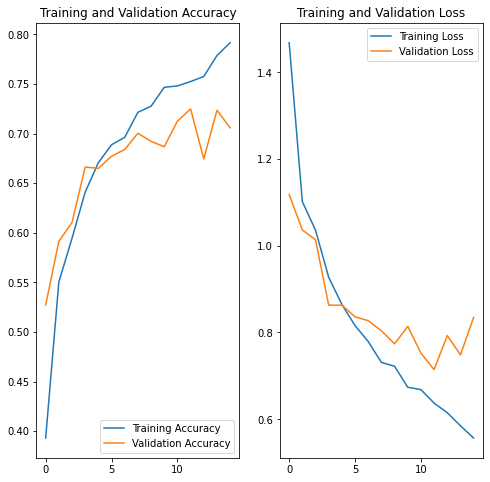

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 133ms/step


This image most likely belongs to sunflowers with a 98.02 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3i5ygcg_/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3i5ygcg_/assets


2022-08-12 01:24:35.718986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-12 01:24:35.719067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

assert np.allclose(predictions, predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 98.02 percent confidence.


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).